In [19]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

[*********************100%***********************]  1 of 1 completed


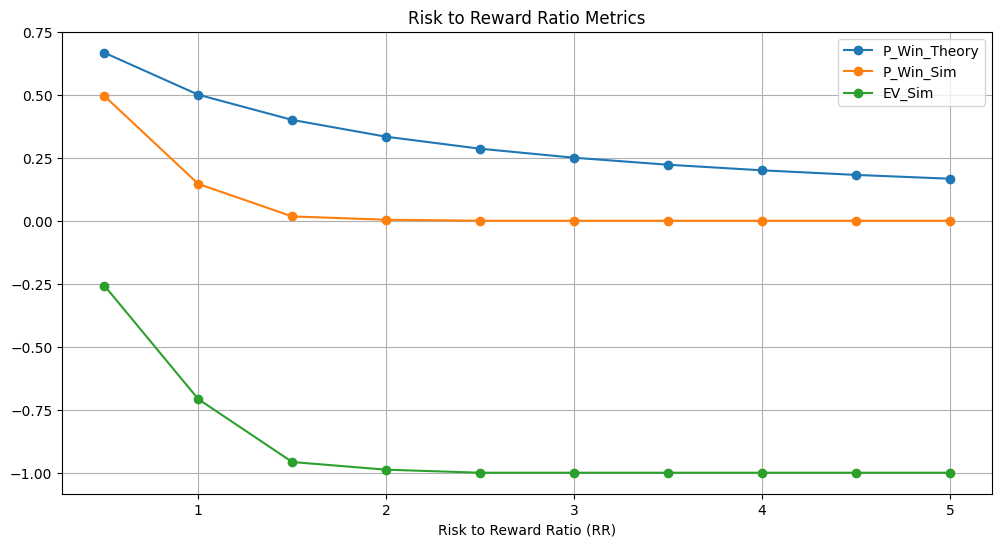

In [ ]:
TICKER = 'SPY'
INTERVAL='1m'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

LOOKBACK = 10000

RR_LIST = [.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):
    df = yf.download(ticker, interval=interval, auto_adjust=True, period=PERIOD)
    df.columns = df.columns.get_level_values(0)
    df = df.reset_index(drop=True)

    for c in df.columns:
        df[f'{c}_Change'] = df[c].pct_change()

    # only return the subset of data you are interested in
    subset = df.iloc[-lookback:, :]

    return subset.dropna()

def simulate_movements(rr_list, std, mu, steps, iters):

    rows = []

    # test the effectiveness of all rr ratios by simulating (iters) movements over the course of (steps) periods. 
    for R in rr_list:

        up, down = R/100, 1/100
        Z = np.random.standard_normal((steps, iters))
        movements = np.cumsum(mu + Z*std, axis=0)

        tp = movements > up
        sl = movements < -down

        tp_first = np.where(tp.any(axis=0), tp.argmax(axis=0), steps+1)
        sl_first = np.where(sl.any(axis=0), sl.argmax(axis=0), steps+1)

        hit_tp = tp_first < sl_first
        p_sim = hit_tp.mean()

        ev_sim = p_sim*R - (1 - p_sim)
        rows.append({"RR":R, "P_Win_Theory":1/(1+R), "P_Win_Sim":p_sim, "EV_Sim":ev_sim})

    return pd.DataFrame(rows)

def main():
    df = get_data()
    mu = df['Close_Change'].mean()
    std = df['Close_Change'].std()
    sim = simulate_movements(
        rr_list=RR_LIST,
        std=std,   # this shuold always be the actual standard deviation of the asset you're working with - df['Close_Change'].std()
        mu=mu,     # default should be 0. Any adjustment to it adds a bias to the study based on outdated information.
        steps=450, # limiting steps to the number of minutes in a trading day significantly reduces your win rate.
        iters=1000 # for ideal robustness, set to 10000
    )

    plt.figure(figsize=(12, 6))
    plt.grid()

    plt.title('Risk to Reward Ratio Metrics')
    plt.plot(sim['RR'], sim['P_Win_Theory'], marker='o')
    plt.plot(sim['RR'], sim['P_Win_Sim'], marker='o')
    plt.plot(sim['RR'], sim['EV_Sim'], marker='o')

    plt.xlabel("Risk to Reward Ratio (RR)")
    plt.legend(['P_Win_Theory', 'P_Win_Sim', 'EV_Sim'])

    return sim

sim = main() # fascingating stuff. Stay Sharp!

In [21]:
sim

,RR,P_Win_Theory,P_Win_Sim,EV_Sim
0,0.5,0.666667,0.495,-0.2575
1,1.0,0.500000,0.146,-0.7080
2,1.5,0.400000,0.017,-0.9575
3,2.0,0.333333,0.004,-0.9880
4,2.5,0.285714,0.000,-1.0000
5,3.0,0.250000,0.000,-1.0000
6,3.5,0.222222,0.000,-1.0000
7,4.0,0.200000,0.000,-1.0000
8,4.5,0.181818,0.000,-1.0000
9,5.0,0.166667,0.000,-1.0000
